In [1]:
##THE HYBRID WITH SLIME AND IALS RESULTS ARE BETTER THAN ANY OTHER ALGORITHM TESTED BEFORE
import os

os.chdir('/Users/gabriele/PycharmProjects/RecSys')
from Utils.utils import create_URM, create_ICM, combine_matrices, create_submission, write_submission
from src.Evaluation.Evaluator import EvaluatorHoldout
from src.Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
##NON-PERSONALIZED
from src.Recommenders.Base.NonPersonalizedRecommender import TopPop

#KNN
from src.Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from src.Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from src.Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from src.Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from src.Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender

#MATRIX-FACTORIZATION
from src.Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from src.Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from src.Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_FunkSVD_Cython, MatrixFactorization_AsySVD_Cython
from src.Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDItemRecommender
from src.Recommenders.MatrixFactorization.IALSRecommenderLinear import IALSRecommender
from src.Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

#GRAPHIC-BASED
from src.Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from src.Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender

#HYBRID
from src.Hybrids.MergingModelsByScores import MergeThreeModelsByScores, MergeTwoModelsByScores

In [2]:
##CREATION OF MATRICES AND SPLITTING IN TRAIN-TEST-VALIDATION
URM = create_URM()
ICM = create_ICM()
URM_stacked = combine_matrices(ICM=ICM, URM=URM)

In [3]:
URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage=0.85)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage=0.85)
stacked_train = combine_matrices(ICM=ICM, URM=URM_train)
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13637 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13627 ( 0.2%) Users that have less than 1 test interactions


In [4]:
import numpy as np 
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
profile_length, profile_length.shape

(array([124, 446, 108, ..., 180, 130, 235], dtype=int32), (13650,))

In [5]:
block_size = int(len(profile_length)*0.05)
block_size

682

In [6]:
sorted_users = np.argsort(profile_length)
sorted_users

array([12441, 10647,  9021, ...,  1141,  8526,   317])

In [7]:
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 682, average p.len 29.20, median 29.5, min 4, max 49
Group 1, #users in group 682, average p.len 66.35, median 67.0, min 49, max 81
Group 2, #users in group 682, average p.len 94.50, median 95.0, min 81, max 107
Group 3, #users in group 682, average p.len 118.74, median 119.0, min 107, max 129
Group 4, #users in group 682, average p.len 139.46, median 140.0, min 129, max 149
Group 5, #users in group 682, average p.len 158.47, median 158.0, min 149, max 167
Group 6, #users in group 682, average p.len 176.78, median 177.0, min 167, max 186
Group 7, #users in group 682, average p.len 196.62, median 197.0, min 186, max 207
Group 8, #users in group 682, average p.len 216.76, median 216.0, min 207, max 227
Group 9, #users in group 682, average p.len 235.99, median 236.0, min 227, max 245
Group 10, #users in group 682, average p.len 254.93, median 255.0, min 245, max 265
Group 11, #users in group 682, average p.len 276.16, median 276.0, min 265, max 287
Group 12, #use

In [8]:
##CREATION OF DIFFERENT RECOMMENDERS TUNED

### RP3Beta Recommender
RP3Beta_recommender = RP3betaRecommender(URM_train=URM_train)
RP3Beta_recommender.fit(topK=181, alpha=0.5709402717259106, beta=0.3566066452521787, implicit=True, normalize_similarity=True)

In [9]:
##SLIMELASTICNET Recommender
SLIME_recommender = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train=stacked_train)
SLIME_recommender.fit(topK=420, l1_ratio=0.06061216785568925, alpha=0.00554982938879437, workers = 10)

100%|████████████████████████████████████▉| 18000/18059 [07:56<00:00, 65.67it/s]

In [10]:
## IALS Recommender
IALS_recommender = IALSRecommender(URM_train=stacked_train)
IALS_recommender.fit(epochs=10, num_factors=42, alpha=0.7617528864750021, reg=8.926401306541349)

IALSRecommenderLinear: Epoch 1 of 10. Elapsed time 8.84 sec


100%|████████████████████████████████████▉| 18056/18059 [08:10<00:00, 65.67it/s]

IALSRecommenderLinear: Epoch 2 of 10. Elapsed time 16.74 sec
IALSRecommenderLinear: Epoch 3 of 10. Elapsed time 24.39 sec
IALSRecommenderLinear: Epoch 4 of 10. Elapsed time 31.99 sec
IALSRecommenderLinear: Epoch 5 of 10. Elapsed time 38.94 sec
IALSRecommenderLinear: Epoch 6 of 10. Elapsed time 46.17 sec
IALSRecommenderLinear: Epoch 7 of 10. Elapsed time 53.43 sec
IALSRecommenderLinear: Epoch 8 of 10. Elapsed time 1.02 min
IALSRecommenderLinear: Epoch 9 of 10. Elapsed time 1.17 min
IALSRecommenderLinear: Epoch 10 of 10. Elapsed time 1.31 min
IALSRecommenderLinear: Terminating at epoch 10. Elapsed time 1.31 min


In [11]:
##P3ALPHA Recommender
P3Alpha_recommender = P3alphaRecommender(URM_train=stacked_train)
P3Alpha_recommender.fit(topK=46,alpha=0.7723235971713814, implicit=True, normalize_similarity=False)

In [12]:
##UserKNNCF
UserKNNCF_recommender = UserKNNCFRecommender(URM_train = stacked_train)
UserKNNCF_recommender.fit(topK=450, shrink=5.0, similarity="tanimoto")

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13984 (100.0%), 1076.24 column/sec. Elapsed time 12.99 sec


In [13]:
hybrid1_recommenders = [SLIME_recommender, IALS_recommender,RP3Beta_recommender ]

##SLIME_RP3BETA_IALS
SLIM_RP3_IALS_recommender = MergeThreeModelsByScores(stacked_train,hybrid1_recommenders)
SLIM_RP3_IALS_recommender.fit(alpha=0.8257646978659972, beta=0.271877679621908, gamma=0.2321636664081369)

In [14]:
##RP3_USERCF
RP3_USERCF = MergeTwoModelsByScores(URM_train = stacked_train, recommenders = [IALS_recommender, RP3Beta_recommender])
RP3_USERCF.fit(alpha=0.2050127521650999,beta=0.0695831691148693)

In [15]:
##RP3_P3A
similarity_rp3= RP3Beta_recommender.W_sparse
similarity_p3a=P3Alpha_recommender.W_sparse
RP3_P3A = ItemKNNSimilarityHybridRecommender(URM_train = stacked_train, Similarity_1 = similarity_rp3, Similarity_2=similarity_p3a )
RP3_P3A.fit(alpha=0.9849405466567409)

In [16]:
##IALS_USERCF
IALS_USERCF_RECS=[IALS_recommender, UserKNNCF_recommender]
IALS_USERCF = MergeTwoModelsByScores(URM_train=stacked_train,recommenders=IALS_USERCF_RECS )
IALS_USERCF.fit(alpha=0.16594460134123257, beta=0.7261566731199409)

In [17]:
##RP3HYBRIDSLIME_IALS
similarity_slime = SLIME_recommender.W_sparse
similarity_rp3 = RP3Beta_recommender.W_sparse

similarity_hybrid = ItemKNNSimilarityHybridRecommender(URM_train = stacked_train,
                                                      Similarity_1 = similarity_rp3,
                                                      Similarity_2 = similarity_slime)
similarity_hybrid.fit(topK=494, alpha=0.1597863887003789 )
recommenders =[similarity_hybrid,IALS_recommender]
hybrid = MergeTwoModelsByScores(stacked_train, recommenders)
hybrid.fit(alpha=0.4555360263375717,beta=0.13654581079541908)

In [18]:
SLIM_RP3hP3A = ItemKNNSimilarityHybridRecommender(URM_train = stacked_train,
                                                      Similarity_1 = SLIME_recommender.W_sparse,
                                                      Similarity_2 = RP3_P3A.W_sparse)
SLIM_RP3hP3A.fit(topK=472, alpha=0.7553063200728594 )



In [19]:
##SLIM_RP3hP3A_IALS
SLIM_RP3hP3A_IALS = MergeTwoModelsByScores(stacked_train,recommenders= [SLIM_RP3hP3A, IALS_USERCF ])
SLIM_RP3hP3A_IALS.fit(alpha=0.9, beta=0.3)

In [20]:
##SLIM_IALS_USERCF
SLIM_IALS_USERCF = MergeTwoModelsByScores(stacked_train,recommenders= [SLIME_recommender, IALS_USERCF ])
SLIM_IALS_USERCF.fit(alpha=0.9278735832759094, beta=0.13893876490152685)

In [21]:
##IALS_USERCF_RP3_P3A
IALS_USERCF_RP3_P3A = MergeTwoModelsByScores(stacked_train,recommenders= [IALS_USERCF, RP3_P3A ])
IALS_USERCF_RP3_P3A.fit(alpha=0.15552658589677892, beta=0.8811147681927525)

In [22]:
##PURE_SVD
PURE_SVD = PureSVDItemRecommender(stacked_train)
PURE_SVD.fit(num_factors=23,topK=561)

PureSVDItemRecommender: Computing SVD decomposition...
PureSVDItemRecommender: Computing SVD decomposition... Done!


In [23]:
USERCF_PURESVD=MergeTwoModelsByScores(URM_train=stacked_train, recommenders=[UserKNNCF_recommender,PURE_SVD])
USERCF_PURESVD.fit(alpha=0.14062495687439416, beta=1.0)

In [31]:
##SLIM_BPR
SLIM_BPR= SLIM_BPR_Cython(URM_train=stacked_train)
SLIM_BPR.fit(epochs=99, topK=70, lambda_i=0.0671681415784431, lambda_j=0.005615678165373237)

/bin/sh: free: command not found


Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 13984 (100.0%) in 2.28 sec. BPR loss is 2.50E-04. Sample per second: 6131
SLIM_BPR_Recommender: Epoch 1 of 99. Elapsed time 1.80 sec
Processed 13984 (100.0%) in 1.43 sec. BPR loss is 9.10E-04. Sample per second: 9773
SLIM_BPR_Recommender: Epoch 2 of 99. Elapsed time 2.94 sec
Processed 13984 (100.0%) in 1.42 sec. BPR loss is 1.65E-03. Sample per second: 9818
SLIM_BPR_Recommender: Epoch 3 of 99. Elapsed time 3.94 sec
Processed 13984 (100.0%) in 1.42 sec. BPR loss is 2.44E-03. Sample per second: 9866
SLIM_BPR_Recommender: Epoch 4 of 99. Elapsed time 4.93 sec
Processed 13984 (100.0%) in 1.46 sec. BPR loss is 3.30E-03. Sample per second: 9585
SLIM_BPR_Recommender: Epoch 5 of 99. Elapsed time 5.97 sec
Processed 13984 (100.0%) in 2.03 sec. BPR loss is 4.11E-03. Sampl

Processed 13984 (100.0%) in 1.40 sec. BPR loss is 4.36E-02. Sample per second: 9990
SLIM_BPR_Recommender: Epoch 56 of 99. Elapsed time 36.91 sec
Processed 13984 (100.0%) in 0.91 sec. BPR loss is 4.59E-02. Sample per second: 15313
SLIM_BPR_Recommender: Epoch 57 of 99. Elapsed time 37.43 sec
Processed 13984 (100.0%) in 1.63 sec. BPR loss is 4.88E-02. Sample per second: 8527
SLIM_BPR_Recommender: Epoch 58 of 99. Elapsed time 38.15 sec
Processed 13984 (100.0%) in 1.48 sec. BPR loss is 4.76E-02. Sample per second: 9438
SLIM_BPR_Recommender: Epoch 59 of 99. Elapsed time 39.00 sec
Processed 13984 (100.0%) in 1.08 sec. BPR loss is 4.78E-02. Sample per second: 12900
SLIM_BPR_Recommender: Epoch 60 of 99. Elapsed time 39.60 sec
Processed 13984 (100.0%) in 0.55 sec. BPR loss is 4.93E-02. Sample per second: 25074
SLIM_BPR_Recommender: Epoch 61 of 99. Elapsed time 40.07 sec
Processed 13984 (100.0%) in 1.14 sec. BPR loss is 4.79E-02. Sample per second: 12308
SLIM_BPR_Recommender: Epoch 62 of 99. Elap

In [41]:
##ITEMCFCBF
ITEMCFCBF=ItemKNN_CFCBF_Hybrid_Recommender(ICM_train=ICM,URM_train=URM_train)
ITEMCFCBF.fit(topK=174, ICM_weight=0.1, shrink=10, similarity='cosine')

ItemKNN_CFCBF_HybridRecommender: ICM Detected 1 ( 0.0%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 1134.16 column/sec. Elapsed time 15.92 sec


In [57]:
##ITEMCFCBF_SLIM_IALS
from src.HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from skopt.space import Real, Integer
from src.HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs

hyperparameters_range_dictionary = {
    "alpha": Real(0.0, 1.0),
    "beta": Real(0.0, 1.0)
}


recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[stacked_train,[ITEMCFCBF_SLIM,IALS_recommender]],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)
recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[URM_train_validation],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)

tuning_class = SearchBayesianSkopt(recommender_class=MergeTwoModelsByScores,
                                   evaluator_validation=evaluator_validation,
                                   evaluator_test=evaluator_test)

n_cases = 50
n_random_starts = n_cases * 0.3
output_folder_path = "logs/"

tuning_class.search(recommender_input_args=recommender_input_args,
                    hyperparameter_search_space=hyperparameters_range_dictionary,
                    metric_to_optimize="MAP",
                    cutoff_to_optimize=10,
                    n_cases=n_cases,
                    n_random_starts=n_random_starts,
                    output_folder_path=output_folder_path,
                    output_file_name_root=MergeTwoModelsByScores.RECOMMENDER_NAME,
                    save_model="best"
                    )

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'alpha': 0.7557588988716336, 'beta': 0.15300039850713157}
EvaluatorHoldout: Processed 13627 (100.0%) in 20.16 sec. Users per second: 676
SearchBayesianSkopt: New best config found. Config 0: {'alpha': 0.7557588988716336, 'beta': 0.15300039850713157} - results: PRECISION: 0.2213620, PRECISION_RECALL_MIN_DEN: 0.2249506, RECALL: 0.0629835, MAP: 0.1052093, MAP_MIN_DEN: 0.1068004, MRR: 0.4439286, NDCG: 0.2294552, F1: 0.0980649, HIT_RATE: 0.9004917, ARHR_ALL_HITS: 0.6817396, NOVELTY: 0.0055529, AVERAGE_POPULARITY: 0.5363944, DIVERSITY_MEAN_INTER_LIST: 0.9176089, DIVERSITY_HERFINDAHL: 0.9917542, COVERAGE_ITEM: 0.0955202, COVERAGE_ITEM_CORRECT: 0.0522731, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8989744, DIVERSITY_GINI: 0.0121533, SHANNON_ENTROPY: 7.9857480, RATIO_DIVERSITY_HERFINDAHL: 0.9921268, RATIO_DIVERSITY_GINI: 0.0468676, RATIO_SHANNON_ENTROPY: 0.6417234, RATIO_AVERAGE_POPULARIT

EvaluatorHoldout: Processed 13627 (100.0%) in 19.56 sec. Users per second: 697
SearchBayesianSkopt: Config 5 is suboptimal. Config: {'alpha': 0.9306702705371748, 'beta': 0.9305724485731471} - results: PRECISION: 0.2205988, PRECISION_RECALL_MIN_DEN: 0.2240420, RECALL: 0.0624063, MAP: 0.1049815, MAP_MIN_DEN: 0.1065623, MRR: 0.4429626, NDCG: 0.2288475, F1: 0.0972898, HIT_RATE: 0.8974096, ARHR_ALL_HITS: 0.6804897, NOVELTY: 0.0055379, AVERAGE_POPULARITY: 0.5345861, DIVERSITY_MEAN_INTER_LIST: 0.9229500, DIVERSITY_HERFINDAHL: 0.9922882, COVERAGE_ITEM: 0.0724846, COVERAGE_ITEM_CORRECT: 0.0449637, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8958974, DIVERSITY_GINI: 0.0112074, SHANNON_ENTROPY: 7.9562617, RATIO_DIVERSITY_HERFINDAHL: 0.9926611, RATIO_DIVERSITY_GINI: 0.0432198, RATIO_SHANNON_ENTROPY: 0.6393539, RATIO_AVERAGE_POPULARITY: 2.6729054, RATIO_NOVELTY: 0.0289687, 

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 19.7066
Function value obtained: -0.1050
Current m

EvaluatorHoldout: Processed 13627 (100.0%) in 19.61 sec. Users per second: 695
SearchBayesianSkopt: Config 12 is suboptimal. Config: {'alpha': 0.039132002117131644, 'beta': 0.698799956282786} - results: PRECISION: 0.2135540, PRECISION_RECALL_MIN_DEN: 0.2168045, RECALL: 0.0600401, MAP: 0.1012087, MAP_MIN_DEN: 0.1027050, MRR: 0.4360530, NDCG: 0.2221488, F1: 0.0937286, HIT_RATE: 0.8884567, ARHR_ALL_HITS: 0.6626439, NOVELTY: 0.0055561, AVERAGE_POPULARITY: 0.5167327, DIVERSITY_MEAN_INTER_LIST: 0.9359969, DIVERSITY_HERFINDAHL: 0.9935928, COVERAGE_ITEM: 0.0540451, COVERAGE_ITEM_CORRECT: 0.0413644, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8869597, DIVERSITY_GINI: 0.0118406, SHANNON_ENTROPY: 8.0956876, RATIO_DIVERSITY_HERFINDAHL: 0.9939661, RATIO_DIVERSITY_GINI: 0.0456614, RATIO_SHANNON_ENTROPY: 0.6505580, RATIO_AVERAGE_POPULARITY: 2.5836393, RATIO_NOVELTY: 0.0290639, 

Iteration No: 13 ended. Evaluation done at random point.
Time taken: 19.7608
Function value obtained: -0.1012
Curren

Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 21.5850
Function value obtained: -0.1053
Current minimum: -0.1053
Iteration No: 20 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.0035463073769383966, 'beta': 0.9920214538779409}
EvaluatorHoldout: Processed 13627 (100.0%) in 19.17 sec. Users per second: 711
SearchBayesianSkopt: Config 19 is suboptimal. Config: {'alpha': 0.0035463073769383966, 'beta': 0.9920214538779409} - results: PRECISION: 0.2125926, PRECISION_RECALL_MIN_DEN: 0.2157980, RECALL: 0.0596943, MAP: 0.1006435, MAP_MIN_DEN: 0.1021269, MRR: 0.4357117, NDCG: 0.2212784, F1: 0.0932146, HIT_RATE: 0.8876495, ARHR_ALL_HITS: 0.6605513, NOVELTY: 0.0055598, AVERAGE_POPULARITY: 0.5141593, DIVERSITY_MEAN_INTER_LIST: 0.9375065, DIVERSITY_HERFINDAHL: 0.9937438, COVERAGE_ITEM: 0.0536021, COVERAGE_ITEM_CORRECT: 0.0414752, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8861538, DIVERSITY_GINI: 0.0120038, SHANN

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 20.0682
Function value obtained: -0.1031
Current minimum: -0.1053
Iteration No: 26 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 1.0, 'beta': 1.0}
EvaluatorHoldout: Processed 13627 (100.0%) in 19.35 sec. Users per second: 704
SearchBayesianSkopt: Config 25 is suboptimal. Config: {'alpha': 1.0, 'beta': 1.0} - results: PRECISION: 0.2206061, PRECISION_RECALL_MIN_DEN: 0.2240493, RECALL: 0.0624084, MAP: 0.1049846, MAP_MIN_DEN: 0.1065654, MRR: 0.4429626, NDCG: 0.2288515, F1: 0.0972930, HIT_RATE: 0.8974096, ARHR_ALL_HITS: 0.6804940, NOVELTY: 0.0055379, AVERAGE_POPULARITY: 0.5345850, DIVERSITY_MEAN_INTER_LIST: 0.9229509, DIVERSITY_HERFINDAHL: 0.9922883, COVERAGE_ITEM: 0.0724846, COVERAGE_ITEM_CORRECT: 0.0449637, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8958974, DIVERSITY_GINI: 0.0112075, SHANNON_ENTROPY: 7.9562702, RATIO_DIVERSITY_HERFINDAHL: 0.9926611, RATI

EvaluatorHoldout: Processed 13627 (100.0%) in 19.69 sec. Users per second: 692
SearchBayesianSkopt: Config 31 is suboptimal. Config: {'alpha': 0.6659046000862796, 'beta': 0.5564734873214949} - results: PRECISION: 0.2208703, PRECISION_RECALL_MIN_DEN: 0.2244477, RECALL: 0.0627623, MAP: 0.1050032, MAP_MIN_DEN: 0.1066147, MRR: 0.4426724, NDCG: 0.2290123, F1: 0.0977485, HIT_RATE: 0.8986571, ARHR_ALL_HITS: 0.6803198, NOVELTY: 0.0055385, AVERAGE_POPULARITY: 0.5354456, DIVERSITY_MEAN_INTER_LIST: 0.9219593, DIVERSITY_HERFINDAHL: 0.9921892, COVERAGE_ITEM: 0.0754748, COVERAGE_ITEM_CORRECT: 0.0461266, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8971429, DIVERSITY_GINI: 0.0112565, SHANNON_ENTROPY: 7.9529637, RATIO_DIVERSITY_HERFINDAHL: 0.9925620, RATIO_DIVERSITY_GINI: 0.0434091, RATIO_SHANNON_ENTROPY: 0.6390889, RATIO_AVERAGE_POPULARITY: 2.6772032, RATIO_NOVELTY: 0.0289719, 

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 20.0313
Function value obtained: -0.1

EvaluatorHoldout: Processed 13627 (100.0%) in 18.91 sec. Users per second: 721
SearchBayesianSkopt: Config 38 is suboptimal. Config: {'alpha': 1.0, 'beta': 0.17307387732960564} - results: PRECISION: 0.2212519, PRECISION_RECALL_MIN_DEN: 0.2248575, RECALL: 0.0629753, MAP: 0.1052851, MAP_MIN_DEN: 0.1068876, MRR: 0.4445156, NDCG: 0.2295151, F1: 0.0980441, HIT_RATE: 0.9001981, ARHR_ALL_HITS: 0.6823422, NOVELTY: 0.0055551, AVERAGE_POPULARITY: 0.5359910, DIVERSITY_MEAN_INTER_LIST: 0.9175783, DIVERSITY_HERFINDAHL: 0.9917511, COVERAGE_ITEM: 0.0973476, COVERAGE_ITEM_CORRECT: 0.0529376, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8986813, DIVERSITY_GINI: 0.0122646, SHANNON_ENTROPY: 7.9926561, RATIO_DIVERSITY_HERFINDAHL: 0.9921237, RATIO_DIVERSITY_GINI: 0.0472966, RATIO_SHANNON_ENTROPY: 0.6422785, RATIO_AVERAGE_POPULARITY: 2.6799301, RATIO_NOVELTY: 0.0290586, 

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 19.2613
Function value obtained: -0.1053
Current mi

EvaluatorHoldout: Processed 13627 (100.0%) in 18.84 sec. Users per second: 723
SearchBayesianSkopt: Config 45 is suboptimal. Config: {'alpha': 0.019883638709352506, 'beta': 0.2773067613678791} - results: PRECISION: 0.2137301, PRECISION_RECALL_MIN_DEN: 0.2170557, RECALL: 0.0601918, MAP: 0.1013058, MAP_MIN_DEN: 0.1028108, MRR: 0.4360180, NDCG: 0.2223160, F1: 0.0939304, HIT_RATE: 0.8889704, ARHR_ALL_HITS: 0.6629098, NOVELTY: 0.0055547, AVERAGE_POPULARITY: 0.5175747, DIVERSITY_MEAN_INTER_LIST: 0.9355289, DIVERSITY_HERFINDAHL: 0.9935460, COVERAGE_ITEM: 0.0547096, COVERAGE_ITEM_CORRECT: 0.0413090, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8874725, DIVERSITY_GINI: 0.0117919, SHANNON_ENTROPY: 8.0885918, RATIO_DIVERSITY_HERFINDAHL: 0.9939193, RATIO_DIVERSITY_GINI: 0.0454739, RATIO_SHANNON_ENTROPY: 0.6499878, RATIO_AVERAGE_POPULARITY: 2.5878493, RATIO_NOVELTY: 0.0290569, 

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 19.2039
Function value obtained: -0

In [94]:
##ITEMCFCBF_SLIM_HYBRID
from src.HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from skopt.space import Real, Integer
from src.HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs

hyperparameters_range_dictionary = {
    "alpha": Real(0.0, 1.0),
    "beta": Real(0.0, 1.0)
}


recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[stacked_train,[ITEMCFCBF_SLIM_IALS2,hybrid]],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)
recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[URM_train_validation],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)

tuning_class = SearchBayesianSkopt(recommender_class=MergeTwoModelsByScores,
                                   evaluator_validation=evaluator_validation,
                                   evaluator_test=evaluator_test)

n_cases = 100
n_random_starts = n_cases * 0.3
output_folder_path = "logs/"

tuning_class.search(recommender_input_args=recommender_input_args,
                    hyperparameter_search_space=hyperparameters_range_dictionary,
                    metric_to_optimize="MAP",
                    cutoff_to_optimize=10,
                    n_cases=n_cases,
                    n_random_starts=n_random_starts,
                    output_folder_path=output_folder_path,
                    output_file_name_root=MergeTwoModelsByScores.RECOMMENDER_NAME,
                    save_model="best"
                    )

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'alpha': 0.6861016498413798, 'beta': 0.06450355382217922}
EvaluatorHoldout: Processed 13627 (100.0%) in 28.08 sec. Users per second: 485
SearchBayesianSkopt: New best config found. Config 0: {'alpha': 0.6861016498413798, 'beta': 0.06450355382217922} - results: PRECISION: 0.2218096, PRECISION_RECALL_MIN_DEN: 0.2254033, RECALL: 0.0631767, MAP: 0.1052322, MAP_MIN_DEN: 0.1068527, MRR: 0.4430059, NDCG: 0.2296715, F1: 0.0983429, HIT_RATE: 0.9009320, ARHR_ALL_HITS: 0.6815295, NOVELTY: 0.0055437, AVERAGE_POPULARITY: 0.5368666, DIVERSITY_MEAN_INTER_LIST: 0.9190695, DIVERSITY_HERFINDAHL: 0.9919002, COVERAGE_ITEM: 0.0845562, COVERAGE_ITEM_CORRECT: 0.0482308, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8994139, DIVERSITY_GINI: 0.0115830, SHANNON_ENTROPY: 7.9578549, RATIO_DIVERSITY_HERFINDAHL: 0.9922729, RATIO_DIVERSITY_GINI: 0.0446681, RATIO_SHANNON_ENTROPY: 0.6394820, RATIO_AVERAGE_POPULARIT

EvaluatorHoldout: Processed 13627 (100.0%) in 29.52 sec. Users per second: 462
SearchBayesianSkopt: Config 5 is suboptimal. Config: {'alpha': 0.4790188626068129, 'beta': 0.6615837467949093} - results: PRECISION: 0.2216702, PRECISION_RECALL_MIN_DEN: 0.2252857, RECALL: 0.0631562, MAP: 0.1051860, MAP_MIN_DEN: 0.1067874, MRR: 0.4432603, NDCG: 0.2295762, F1: 0.0983044, HIT_RATE: 0.9015190, ARHR_ALL_HITS: 0.6814236, NOVELTY: 0.0055590, AVERAGE_POPULARITY: 0.5313887, DIVERSITY_MEAN_INTER_LIST: 0.9202665, DIVERSITY_HERFINDAHL: 0.9920199, COVERAGE_ITEM: 0.0872695, COVERAGE_ITEM_CORRECT: 0.0502796, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.9000000, DIVERSITY_GINI: 0.0120900, SHANNON_ENTROPY: 8.0088160, RATIO_DIVERSITY_HERFINDAHL: 0.9923926, RATIO_DIVERSITY_GINI: 0.0466232, RATIO_SHANNON_ENTROPY: 0.6435771, RATIO_AVERAGE_POPULARITY: 2.6569185, RATIO_NOVELTY: 0.0290793, 

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 29.6751
Function value obtained: -0.1052
Current m

EvaluatorHoldout: Processed 13627 (100.0%) in 26.24 sec. Users per second: 519
SearchBayesianSkopt: Config 12 is suboptimal. Config: {'alpha': 0.0426318058391696, 'beta': 0.2164920883191021} - results: PRECISION: 0.2220738, PRECISION_RECALL_MIN_DEN: 0.2256595, RECALL: 0.0632115, MAP: 0.1054650, MAP_MIN_DEN: 0.1070619, MRR: 0.4438469, NDCG: 0.2299660, F1: 0.0984110, HIT_RATE: 0.9018860, ARHR_ALL_HITS: 0.6826351, NOVELTY: 0.0055742, AVERAGE_POPULARITY: 0.5259075, DIVERSITY_MEAN_INTER_LIST: 0.9215271, DIVERSITY_HERFINDAHL: 0.9921459, COVERAGE_ITEM: 0.0896506, COVERAGE_ITEM_CORRECT: 0.0522731, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.9003663, DIVERSITY_GINI: 0.0126018, SHANNON_ENTROPY: 8.0591812, RATIO_DIVERSITY_HERFINDAHL: 0.9925187, RATIO_DIVERSITY_GINI: 0.0485969, RATIO_SHANNON_ENTROPY: 0.6476244, RATIO_AVERAGE_POPULARITY: 2.6295128, RATIO_NOVELTY: 0.0291589, 

Iteration No: 13 ended. Evaluation done at random point.
Time taken: 26.3493
Function value obtained: -0.1055
Current

EvaluatorHoldout: Processed 13627 (100.0%) in 26.35 sec. Users per second: 517
SearchBayesianSkopt: Config 19 is suboptimal. Config: {'alpha': 0.23818052574765874, 'beta': 0.7612467266376541} - results: PRECISION: 0.2221179, PRECISION_RECALL_MIN_DEN: 0.2257114, RECALL: 0.0631901, MAP: 0.1055370, MAP_MIN_DEN: 0.1071384, MRR: 0.4445198, NDCG: 0.2301080, F1: 0.0983895, HIT_RATE: 0.9020327, ARHR_ALL_HITS: 0.6833326, NOVELTY: 0.0055690, AVERAGE_POPULARITY: 0.5278023, DIVERSITY_MEAN_INTER_LIST: 0.9210796, DIVERSITY_HERFINDAHL: 0.9921012, COVERAGE_ITEM: 0.0888200, COVERAGE_ITEM_CORRECT: 0.0517194, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.9005128, DIVERSITY_GINI: 0.0124221, SHANNON_ENTROPY: 8.0416866, RATIO_DIVERSITY_HERFINDAHL: 0.9924740, RATIO_DIVERSITY_GINI: 0.0479038, RATIO_SHANNON_ENTROPY: 0.6462186, RATIO_AVERAGE_POPULARITY: 2.6389867, RATIO_NOVELTY: 0.0291317, 

Iteration No: 20 ended. Evaluation done at random point.
Time taken: 26.4729
Function value obtained: -0.1055
Curren

EvaluatorHoldout: Processed 13627 (100.0%) in 26.26 sec. Users per second: 519
SearchBayesianSkopt: Config 26 is suboptimal. Config: {'alpha': 0.704496227203905, 'beta': 0.526300998401788} - results: PRECISION: 0.2217436, PRECISION_RECALL_MIN_DEN: 0.2253580, RECALL: 0.0631793, MAP: 0.1052279, MAP_MIN_DEN: 0.1068266, MRR: 0.4432021, NDCG: 0.2296315, F1: 0.0983396, HIT_RATE: 0.9011521, ARHR_ALL_HITS: 0.6815538, NOVELTY: 0.0055532, AVERAGE_POPULARITY: 0.5334889, DIVERSITY_MEAN_INTER_LIST: 0.9198133, DIVERSITY_HERFINDAHL: 0.9919746, COVERAGE_ITEM: 0.0866050, COVERAGE_ITEM_CORRECT: 0.0495044, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8996337, DIVERSITY_GINI: 0.0118997, SHANNON_ENTROPY: 7.9896372, RATIO_DIVERSITY_HERFINDAHL: 0.9923473, RATIO_DIVERSITY_GINI: 0.0458896, RATIO_SHANNON_ENTROPY: 0.6420360, RATIO_AVERAGE_POPULARITY: 2.6674197, RATIO_NOVELTY: 0.0290488, 

Iteration No: 27 ended. Evaluation done at random point.
Time taken: 26.3699
Function value obtained: -0.1052
Current m

SearchBayesianSkopt: Config 32 is suboptimal. Config: {'alpha': 0.887819587415934, 'beta': 0.24582278217831738} - results: PRECISION: 0.2216776, PRECISION_RECALL_MIN_DEN: 0.2252685, RECALL: 0.0631232, MAP: 0.1051788, MAP_MIN_DEN: 0.1067972, MRR: 0.4430552, NDCG: 0.2295685, F1: 0.0982651, HIT_RATE: 0.9011521, ARHR_ALL_HITS: 0.6813232, NOVELTY: 0.0055472, AVERAGE_POPULARITY: 0.5356663, DIVERSITY_MEAN_INTER_LIST: 0.9193190, DIVERSITY_HERFINDAHL: 0.9919252, COVERAGE_ITEM: 0.0854975, COVERAGE_ITEM_CORRECT: 0.0486184, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8996337, DIVERSITY_GINI: 0.0117033, SHANNON_ENTROPY: 7.9696907, RATIO_DIVERSITY_HERFINDAHL: 0.9922978, RATIO_DIVERSITY_GINI: 0.0451322, RATIO_SHANNON_ENTROPY: 0.6404331, RATIO_AVERAGE_POPULARITY: 2.6783063, RATIO_NOVELTY: 0.0290175, 

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 26.8493
Function value obtained: -0.1052
Current minimum: -0.1057
Iteration No: 34 started. Searching for the next o

EvaluatorHoldout: Processed 13627 (100.0%) in 26.62 sec. Users per second: 512
SearchBayesianSkopt: Config 39 is suboptimal. Config: {'alpha': 0.34951004213646714, 'beta': 0.35124039038964333} - results: PRECISION: 0.2216776, PRECISION_RECALL_MIN_DEN: 0.2252930, RECALL: 0.0631617, MAP: 0.1052148, MAP_MIN_DEN: 0.1068157, MRR: 0.4434691, NDCG: 0.2296244, F1: 0.0983118, HIT_RATE: 0.9012989, ARHR_ALL_HITS: 0.6816972, NOVELTY: 0.0055558, AVERAGE_POPULARITY: 0.5325053, DIVERSITY_MEAN_INTER_LIST: 0.9200713, DIVERSITY_HERFINDAHL: 0.9920004, COVERAGE_ITEM: 0.0869926, COVERAGE_ITEM_CORRECT: 0.0498920, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8997802, DIVERSITY_GINI: 0.0119885, SHANNON_ENTROPY: 7.9988648, RATIO_DIVERSITY_HERFINDAHL: 0.9923731, RATIO_DIVERSITY_GINI: 0.0462318, RATIO_SHANNON_ENTROPY: 0.6427775, RATIO_AVERAGE_POPULARITY: 2.6625018, RATIO_NOVELTY: 0.0290625, 

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 27.0380
Function value obtained: -0

EvaluatorHoldout: Processed 13627 (100.0%) in 28.49 sec. Users per second: 478
SearchBayesianSkopt: Config 46 is suboptimal. Config: {'alpha': 0.33226976525035584, 'beta': 0.8597770307993411} - results: PRECISION: 0.2219344, PRECISION_RECALL_MIN_DEN: 0.2255303, RECALL: 0.0631563, MAP: 0.1054220, MAP_MIN_DEN: 0.1070233, MRR: 0.4443650, NDCG: 0.2299291, F1: 0.0983305, HIT_RATE: 0.9021795, ARHR_ALL_HITS: 0.6828052, NOVELTY: 0.0055665, AVERAGE_POPULARITY: 0.5286902, DIVERSITY_MEAN_INTER_LIST: 0.9208876, DIVERSITY_HERFINDAHL: 0.9920820, COVERAGE_ITEM: 0.0883770, COVERAGE_ITEM_CORRECT: 0.0513871, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.9006593, DIVERSITY_GINI: 0.0123447, SHANNON_ENTROPY: 8.0340081, RATIO_DIVERSITY_HERFINDAHL: 0.9924547, RATIO_DIVERSITY_GINI: 0.0476056, RATIO_SHANNON_ENTROPY: 0.6456015, RATIO_AVERAGE_POPULARITY: 2.6434264, RATIO_NOVELTY: 0.0291187, 

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 28.9046
Function value obtained: -0.

EvaluatorHoldout: Processed 13627 (100.0%) in 27.83 sec. Users per second: 490
SearchBayesianSkopt: Config 53 is suboptimal. Config: {'alpha': 0.026345149718834695, 'beta': 0.5548954241516454} - results: PRECISION: 0.2219491, PRECISION_RECALL_MIN_DEN: 0.2255471, RECALL: 0.0632099, MAP: 0.1055153, MAP_MIN_DEN: 0.1071071, MRR: 0.4442947, NDCG: 0.2299888, F1: 0.0983968, HIT_RATE: 0.9020327, ARHR_ALL_HITS: 0.6830975, NOVELTY: 0.0055847, AVERAGE_POPULARITY: 0.5221142, DIVERSITY_MEAN_INTER_LIST: 0.9223816, DIVERSITY_HERFINDAHL: 0.9922314, COVERAGE_ITEM: 0.0910903, COVERAGE_ITEM_CORRECT: 0.0530483, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.9005128, DIVERSITY_GINI: 0.0129266, SHANNON_ENTROPY: 8.0908729, RATIO_DIVERSITY_HERFINDAHL: 0.9926042, RATIO_DIVERSITY_GINI: 0.0498496, RATIO_SHANNON_ENTROPY: 0.6501711, RATIO_AVERAGE_POPULARITY: 2.6105465, RATIO_NOVELTY: 0.0292136, 

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 28.3162
Function value obtained: -0

EvaluatorHoldout: Processed 13627 (100.0%) in 27.47 sec. Users per second: 496
SearchBayesianSkopt: Config 60 is suboptimal. Config: {'alpha': 0.8685216495375385, 'beta': 0.3917083995813698} - results: PRECISION: 0.2216702, PRECISION_RECALL_MIN_DEN: 0.2252694, RECALL: 0.0631424, MAP: 0.1051914, MAP_MIN_DEN: 0.1068176, MRR: 0.4433327, NDCG: 0.2296095, F1: 0.0982877, HIT_RATE: 0.9012989, ARHR_ALL_HITS: 0.6815445, NOVELTY: 0.0055496, AVERAGE_POPULARITY: 0.5347950, DIVERSITY_MEAN_INTER_LIST: 0.9195096, DIVERSITY_HERFINDAHL: 0.9919442, COVERAGE_ITEM: 0.0859405, COVERAGE_ITEM_CORRECT: 0.0490614, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8997802, DIVERSITY_GINI: 0.0117800, SHANNON_ENTROPY: 7.9774958, RATIO_DIVERSITY_HERFINDAHL: 0.9923169, RATIO_DIVERSITY_GINI: 0.0454277, RATIO_SHANNON_ENTROPY: 0.6410603, RATIO_AVERAGE_POPULARITY: 2.6739501, RATIO_NOVELTY: 0.0290301, 

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 27.9714
Function value obtained: -0.1

EvaluatorHoldout: Processed 13627 (100.0%) in 28.76 sec. Users per second: 474
SearchBayesianSkopt: Config 67 is suboptimal. Config: {'alpha': 0.09931754264087603, 'beta': 0.7178664522920738} - results: PRECISION: 0.2218170, PRECISION_RECALL_MIN_DEN: 0.2254108, RECALL: 0.0631589, MAP: 0.1054639, MAP_MIN_DEN: 0.1070572, MRR: 0.4443264, NDCG: 0.2299042, F1: 0.0983221, HIT_RATE: 0.9018860, ARHR_ALL_HITS: 0.6829631, NOVELTY: 0.0055774, AVERAGE_POPULARITY: 0.5247622, DIVERSITY_MEAN_INTER_LIST: 0.9217630, DIVERSITY_HERFINDAHL: 0.9921695, COVERAGE_ITEM: 0.0902043, COVERAGE_ITEM_CORRECT: 0.0524392, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.9003663, DIVERSITY_GINI: 0.0126999, SHANNON_ENTROPY: 8.0686215, RATIO_DIVERSITY_HERFINDAHL: 0.9925423, RATIO_DIVERSITY_GINI: 0.0489755, RATIO_SHANNON_ENTROPY: 0.6483830, RATIO_AVERAGE_POPULARITY: 2.6237866, RATIO_NOVELTY: 0.0291756, 

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 29.3032
Function value obtained: -0.

EvaluatorHoldout: Processed 13627 (100.0%) in 29.14 sec. Users per second: 468
SearchBayesianSkopt: Config 74 is suboptimal. Config: {'alpha': 0.18058916555176496, 'beta': 1.0} - results: PRECISION: 0.2221252, PRECISION_RECALL_MIN_DEN: 0.2257109, RECALL: 0.0632236, MAP: 0.1055017, MAP_MIN_DEN: 0.1070985, MRR: 0.4439529, NDCG: 0.2300237, F1: 0.0984308, HIT_RATE: 0.9019593, ARHR_ALL_HITS: 0.6828279, NOVELTY: 0.0055750, AVERAGE_POPULARITY: 0.5256239, DIVERSITY_MEAN_INTER_LIST: 0.9215932, DIVERSITY_HERFINDAHL: 0.9921526, COVERAGE_ITEM: 0.0899275, COVERAGE_ITEM_CORRECT: 0.0522731, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.9004396, DIVERSITY_GINI: 0.0126280, SHANNON_ENTROPY: 8.0616217, RATIO_DIVERSITY_HERFINDAHL: 0.9925253, RATIO_DIVERSITY_GINI: 0.0486982, RATIO_SHANNON_ENTROPY: 0.6478205, RATIO_AVERAGE_POPULARITY: 2.6280950, RATIO_NOVELTY: 0.0291630, 

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 29.7901
Function value obtained: -0.1055
Current mi

EvaluatorHoldout: Processed 13627 (100.0%) in 29.61 sec. Users per second: 460
SearchBayesianSkopt: Config 81 is suboptimal. Config: {'alpha': 0.6244308503897408, 'beta': 0.5540257189969291} - results: PRECISION: 0.2216409, PRECISION_RECALL_MIN_DEN: 0.2252553, RECALL: 0.0631480, MAP: 0.1051871, MAP_MIN_DEN: 0.1067862, MRR: 0.4432811, NDCG: 0.2295685, F1: 0.0982916, HIT_RATE: 0.9012989, ARHR_ALL_HITS: 0.6814701, NOVELTY: 0.0055547, AVERAGE_POPULARITY: 0.5329531, DIVERSITY_MEAN_INTER_LIST: 0.9199408, DIVERSITY_HERFINDAHL: 0.9919873, COVERAGE_ITEM: 0.0868265, COVERAGE_ITEM_CORRECT: 0.0496705, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8997802, DIVERSITY_GINI: 0.0119492, SHANNON_ENTROPY: 7.9946784, RATIO_DIVERSITY_HERFINDAHL: 0.9923600, RATIO_DIVERSITY_GINI: 0.0460805, RATIO_SHANNON_ENTROPY: 0.6424411, RATIO_AVERAGE_POPULARITY: 2.6647404, RATIO_NOVELTY: 0.0290567, 

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 30.3465
Function value obtained: -0.1

EvaluatorHoldout: Processed 13627 (100.0%) in 31.70 sec. Users per second: 430
SearchBayesianSkopt: Config 88 is suboptimal. Config: {'alpha': 0.3016844135791748, 'beta': 0.7833517730701319} - results: PRECISION: 0.2219271, PRECISION_RECALL_MIN_DEN: 0.2255229, RECALL: 0.0631579, MAP: 0.1054258, MAP_MIN_DEN: 0.1070271, MRR: 0.4444216, NDCG: 0.2299363, F1: 0.0983317, HIT_RATE: 0.9021795, ARHR_ALL_HITS: 0.6828653, NOVELTY: 0.0055666, AVERAGE_POPULARITY: 0.5286806, DIVERSITY_MEAN_INTER_LIST: 0.9208894, DIVERSITY_HERFINDAHL: 0.9920822, COVERAGE_ITEM: 0.0884324, COVERAGE_ITEM_CORRECT: 0.0513871, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.9006593, DIVERSITY_GINI: 0.0123467, SHANNON_ENTROPY: 8.0341572, RATIO_DIVERSITY_HERFINDAHL: 0.9924549, RATIO_DIVERSITY_GINI: 0.0476132, RATIO_SHANNON_ENTROPY: 0.6456135, RATIO_AVERAGE_POPULARITY: 2.6433785, RATIO_NOVELTY: 0.0291189, 

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 32.6788
Function value obtained: -0.1

EvaluatorHoldout: Processed 13627 (100.0%) in 30.40 sec. Users per second: 448
SearchBayesianSkopt: Config 95 is suboptimal. Config: {'alpha': 0.06577136903124071, 'beta': 0.8902945439149709} - results: PRECISION: 0.2218610, PRECISION_RECALL_MIN_DEN: 0.2254590, RECALL: 0.0631920, MAP: 0.1055090, MAP_MIN_DEN: 0.1071009, MRR: 0.4443833, NDCG: 0.2299521, F1: 0.0983666, HIT_RATE: 0.9017392, ARHR_ALL_HITS: 0.6831281, NOVELTY: 0.0055822, AVERAGE_POPULARITY: 0.5229920, DIVERSITY_MEAN_INTER_LIST: 0.9222065, DIVERSITY_HERFINDAHL: 0.9922139, COVERAGE_ITEM: 0.0909796, COVERAGE_ITEM_CORRECT: 0.0527715, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.9002198, DIVERSITY_GINI: 0.0128549, SHANNON_ENTROPY: 8.0838609, RATIO_DIVERSITY_HERFINDAHL: 0.9925867, RATIO_DIVERSITY_GINI: 0.0495730, RATIO_SHANNON_ENTROPY: 0.6496076, RATIO_AVERAGE_POPULARITY: 2.6149358, RATIO_NOVELTY: 0.0292008, 

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 31.3914
Function value obtained: -0.

In [73]:
##ITEMCFCBF_SLIM_IALS_RP3_P3A
from src.HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from skopt.space import Real, Integer
from src.HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs

hyperparameters_range_dictionary = {
    "alpha": Real(0.0, 1.0),
    "beta": Real(0.0, 1.0)
}


recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[stacked_train,[ITEMCFCBF_SLIM_IALS2,RP3_P3A]],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)
recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[URM_train_validation],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)

tuning_class = SearchBayesianSkopt(recommender_class=MergeTwoModelsByScores,
                                   evaluator_validation=evaluator_validation,
                                   evaluator_test=evaluator_test)

n_cases = 50
n_random_starts = n_cases * 0.3
output_folder_path = "logs/"

tuning_class.search(recommender_input_args=recommender_input_args,
                    hyperparameter_search_space=hyperparameters_range_dictionary,
                    metric_to_optimize="MAP",
                    cutoff_to_optimize=10,
                    n_cases=n_cases,
                    n_random_starts=n_random_starts,
                    output_folder_path=output_folder_path,
                    output_file_name_root=MergeTwoModelsByScores.RECOMMENDER_NAME,
                    save_model="best"
                    )

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'alpha': 0.6351411807795133, 'beta': 0.23868910191904363}
EvaluatorHoldout: Processed 13627 (100.0%) in 21.35 sec. Users per second: 638
SearchBayesianSkopt: New best config found. Config 0: {'alpha': 0.6351411807795133, 'beta': 0.23868910191904363} - results: PRECISION: 0.2229398, PRECISION_RECALL_MIN_DEN: 0.2265667, RECALL: 0.0633471, MAP: 0.1061203, MAP_MIN_DEN: 0.1077611, MRR: 0.4452276, NDCG: 0.2310014, F1: 0.0986603, HIT_RATE: 0.9026198, ARHR_ALL_HITS: 0.6860248, NOVELTY: 0.0055353, AVERAGE_POPULARITY: 0.5474606, DIVERSITY_MEAN_INTER_LIST: 0.9066178, DIVERSITY_HERFINDAHL: 0.9906551, COVERAGE_ITEM: 0.0846669, COVERAGE_ITEM_CORRECT: 0.0483969, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.9010989, DIVERSITY_GINI: 0.0109578, SHANNON_ENTROPY: 7.8269731, RATIO_DIVERSITY_HERFINDAHL: 0.9910273, RATIO_DIVERSITY_GINI: 0.0422572, RATIO_SHANNON_ENTROPY: 0.6289645, RATIO_AVERAGE_POPULARIT

EvaluatorHoldout: Processed 13627 (100.0%) in 20.49 sec. Users per second: 665
SearchBayesianSkopt: Config 6 is suboptimal. Config: {'alpha': 0.7996849212520104, 'beta': 0.03226401022535375} - results: PRECISION: 0.2220298, PRECISION_RECALL_MIN_DEN: 0.2256248, RECALL: 0.0632234, MAP: 0.1052980, MAP_MIN_DEN: 0.1069233, MRR: 0.4433028, NDCG: 0.2298782, F1: 0.0984212, HIT_RATE: 0.9016658, ARHR_ALL_HITS: 0.6820867, NOVELTY: 0.0055415, AVERAGE_POPULARITY: 0.5385592, DIVERSITY_MEAN_INTER_LIST: 0.9176552, DIVERSITY_HERFINDAHL: 0.9917588, COVERAGE_ITEM: 0.0843347, COVERAGE_ITEM_CORRECT: 0.0482308, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.9001465, DIVERSITY_GINI: 0.0114770, SHANNON_ENTROPY: 7.9397165, RATIO_DIVERSITY_HERFINDAHL: 0.9921314, RATIO_DIVERSITY_GINI: 0.0442596, RATIO_SHANNON_ENTROPY: 0.6380244, RATIO_AVERAGE_POPULARITY: 2.6927708, RATIO_NOVELTY: 0.0289876, 

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 20.6026
Function value obtained: -0.1053
Current 

EvaluatorHoldout: Processed 13627 (100.0%) in 20.96 sec. Users per second: 650
SearchBayesianSkopt: Config 13 is suboptimal. Config: {'alpha': 0.6124712979120508, 'beta': 0.9785641045263996} - results: PRECISION: 0.2212886, PRECISION_RECALL_MIN_DEN: 0.2247614, RECALL: 0.0625769, MAP: 0.1054840, MAP_MIN_DEN: 0.1070982, MRR: 0.4436572, NDCG: 0.2295620, F1: 0.0975641, HIT_RATE: 0.8978499, ARHR_ALL_HITS: 0.6826328, NOVELTY: 0.0055326, AVERAGE_POPULARITY: 0.5628851, DIVERSITY_MEAN_INTER_LIST: 0.8788246, DIVERSITY_HERFINDAHL: 0.9878760, COVERAGE_ITEM: 0.0852760, COVERAGE_ITEM_CORRECT: 0.0481754, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8963370, DIVERSITY_GINI: 0.0097573, SHANNON_ENTROPY: 7.5544453, RATIO_DIVERSITY_HERFINDAHL: 0.9882472, RATIO_DIVERSITY_GINI: 0.0376275, RATIO_SHANNON_ENTROPY: 0.6070645, RATIO_AVERAGE_POPULARITY: 2.8143991, RATIO_NOVELTY: 0.0289409, 

Iteration No: 14 ended. Evaluation done at random point.
Time taken: 21.1043
Function value obtained: -0.1055
Current

SearchBayesianSkopt: Config 19 is suboptimal. Config: {'alpha': 0.22847509288639545, 'beta': 0.0} - results: PRECISION: 0.2218023, PRECISION_RECALL_MIN_DEN: 0.2253960, RECALL: 0.0631775, MAP: 0.1052479, MAP_MIN_DEN: 0.1068754, MRR: 0.4432118, NDCG: 0.2297244, F1: 0.0983432, HIT_RATE: 0.9010054, ARHR_ALL_HITS: 0.6818298, NOVELTY: 0.0055420, AVERAGE_POPULARITY: 0.5375200, DIVERSITY_MEAN_INTER_LIST: 0.9189067, DIVERSITY_HERFINDAHL: 0.9918839, COVERAGE_ITEM: 0.0843347, COVERAGE_ITEM_CORRECT: 0.0480093, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8994872, DIVERSITY_GINI: 0.0115259, SHANNON_ENTROPY: 7.9516512, RATIO_DIVERSITY_HERFINDAHL: 0.9922566, RATIO_DIVERSITY_GINI: 0.0444478, RATIO_SHANNON_ENTROPY: 0.6389835, RATIO_AVERAGE_POPULARITY: 2.6875747, RATIO_NOVELTY: 0.0289903, 

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 20.9626
Function value obtained: -0.1052
Current minimum: -0.1061
Iteration No: 21 started. Searching for the next optimal point.


EvaluatorHoldout: Processed 13627 (100.0%) in 20.47 sec. Users per second: 666
SearchBayesianSkopt: Config 26 is suboptimal. Config: {'alpha': 0.6333046207473493, 'beta': 0.6553682047616897} - results: PRECISION: 0.2222426, PRECISION_RECALL_MIN_DEN: 0.2257868, RECALL: 0.0629928, MAP: 0.1059952, MAP_MIN_DEN: 0.1076326, MRR: 0.4448022, NDCG: 0.2304925, F1: 0.0981623, HIT_RATE: 0.9005651, ARHR_ALL_HITS: 0.6851626, NOVELTY: 0.0055305, AVERAGE_POPULARITY: 0.5584633, DIVERSITY_MEAN_INTER_LIST: 0.8889914, DIVERSITY_HERFINDAHL: 0.9888926, COVERAGE_ITEM: 0.0847223, COVERAGE_ITEM_CORRECT: 0.0478986, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8990476, DIVERSITY_GINI: 0.0101713, SHANNON_ENTROPY: 7.6520327, RATIO_DIVERSITY_HERFINDAHL: 0.9892642, RATIO_DIVERSITY_GINI: 0.0392241, RATIO_SHANNON_ENTROPY: 0.6149065, RATIO_AVERAGE_POPULARITY: 2.7922902, RATIO_NOVELTY: 0.0289300, 

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 20.7656
Function value obtained: -0.1

EvaluatorHoldout: Processed 13627 (100.0%) in 20.53 sec. Users per second: 664
SearchBayesianSkopt: Config 32 is suboptimal. Config: {'alpha': 0.8592412260309994, 'beta': 0.2668320779451865} - results: PRECISION: 0.2229618, PRECISION_RECALL_MIN_DEN: 0.2265958, RECALL: 0.0633903, MAP: 0.1061158, MAP_MIN_DEN: 0.1077569, MRR: 0.4457551, NDCG: 0.2310617, F1: 0.0987150, HIT_RATE: 0.9029867, ARHR_ALL_HITS: 0.6863062, NOVELTY: 0.0055365, AVERAGE_POPULARITY: 0.5458515, DIVERSITY_MEAN_INTER_LIST: 0.9086793, DIVERSITY_HERFINDAHL: 0.9908613, COVERAGE_ITEM: 0.0847777, COVERAGE_ITEM_CORRECT: 0.0483969, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.9014652, DIVERSITY_GINI: 0.0110592, SHANNON_ENTROPY: 7.8484230, RATIO_DIVERSITY_HERFINDAHL: 0.9912335, RATIO_DIVERSITY_GINI: 0.0426483, RATIO_SHANNON_ENTROPY: 0.6306882, RATIO_AVERAGE_POPULARITY: 2.7292321, RATIO_NOVELTY: 0.0289613, 

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 20.8553
Function value obtained: -0.1

EvaluatorHoldout: Processed 13627 (100.0%) in 20.91 sec. Users per second: 652
SearchBayesianSkopt: Config 38 is suboptimal. Config: {'alpha': 0.5040113482729017, 'beta': 0.5679733637879596} - results: PRECISION: 0.2220371, PRECISION_RECALL_MIN_DEN: 0.2255840, RECALL: 0.0629202, MAP: 0.1059723, MAP_MIN_DEN: 0.1076067, MRR: 0.4450853, NDCG: 0.2304021, F1: 0.0980542, HIT_RATE: 0.8996111, ARHR_ALL_HITS: 0.6852172, NOVELTY: 0.0055306, AVERAGE_POPULARITY: 0.5593512, DIVERSITY_MEAN_INTER_LIST: 0.8871078, DIVERSITY_HERFINDAHL: 0.9887043, COVERAGE_ITEM: 0.0849438, COVERAGE_ITEM_CORRECT: 0.0479539, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8980952, DIVERSITY_GINI: 0.0100980, SHANNON_ENTROPY: 7.6342185, RATIO_DIVERSITY_HERFINDAHL: 0.9890757, RATIO_DIVERSITY_GINI: 0.0389415, RATIO_SHANNON_ENTROPY: 0.6134750, RATIO_AVERAGE_POPULARITY: 2.7967299, RATIO_NOVELTY: 0.0289307, 

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 21.2808
Function value obtained: -0.1

EvaluatorHoldout: Processed 13627 (100.0%) in 21.20 sec. Users per second: 643
SearchBayesianSkopt: Config 45 is suboptimal. Config: {'alpha': 0.1724500707658542, 'beta': 0.9991406897753846} - results: PRECISION: 0.2158215, PRECISION_RECALL_MIN_DEN: 0.2192064, RECALL: 0.0608156, MAP: 0.1029230, MAP_MIN_DEN: 0.1044261, MRR: 0.4402803, NDCG: 0.2247278, F1: 0.0948919, HIT_RATE: 0.8916122, ARHR_ALL_HITS: 0.6709328, NOVELTY: 0.0055609, AVERAGE_POPULARITY: 0.5675244, DIVERSITY_MEAN_INTER_LIST: 0.8511419, DIVERSITY_HERFINDAHL: 0.9851079, COVERAGE_ITEM: 0.0898721, COVERAGE_ITEM_CORRECT: 0.0486738, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8901099, DIVERSITY_GINI: 0.0088134, SHANNON_ENTROPY: 7.3056887, RATIO_DIVERSITY_HERFINDAHL: 0.9854781, RATIO_DIVERSITY_GINI: 0.0339876, RATIO_SHANNON_ENTROPY: 0.5870748, RATIO_AVERAGE_POPULARITY: 2.8375955, RATIO_NOVELTY: 0.0290889, 

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 21.6268
Function value obtained: -0.1

In [46]:
ITEMCFCBF_SLIM = MergeTwoModelsByScores(URM_train = stacked_train, recommenders=[ITEMCFCBF,SLIME_recommender])
ITEMCFCBF_SLIM.fit(alpha=0.006419859589518687,beta=1.0)

In [53]:
ITEMCFCBF_SLIM_PURESVD = MergeTwoModelsByScores(URM_train = stacked_train, recommenders=[ITEMCFCBF_SLIM,PURE_SVD])
ITEMCFCBF_SLIM_PURESVD.fit(alpha=0.540546281787381,beta=0.1785988580388044)

In [63]:

ITEMCFCBF_SLIM_IALS2 = MergeTwoModelsByScores(URM_train = stacked_train, recommenders=[ITEMCFCBF_SLIM,IALS_recommender])
ITEMCFCBF_SLIM_IALS2.fit(alpha=0.7751267998183894,beta=0.35391338107827336)

In [76]:
ITEMCFCBF_SLIM_HYBRID =MergeTwoModelsByScores(URM_train = stacked_train, recommenders=[ITEMCFCBF_SLIM_IALS2,hybrid])
ITEMCFCBF_SLIM_HYBRID.fit(alpha=0.5134425691700654,beta=0.44336807279575097)

In [75]:
ITEMCFCBF_SLIM_IALS_RP3_P3A = MergeTwoModelsByScores(URM_train = stacked_train, recommenders=[ITEMCFCBF_SLIM_IALS2,RP3_P3A])
ITEMCFCBF_SLIM_IALS_RP3_P3A.fit(alpha=0.48283836538126934,beta=0.23855926356461893)

In [77]:
MAP_recommender_per_group = {}

recommenders= {
               "HYBRID": hybrid,
               "ITEMCFCBF_SLIM":ITEMCFCBF_SLIM,
               "ITEMCFCBF_SLIM_PURESVD":ITEMCFCBF_SLIM_PURESVD,
               "ITEMCFCBF_SLIM_IALS2":ITEMCFCBF_SLIM_IALS,
               "ITEMCFCBF_SLIM_HYBRID":ITEMCFCBF_SLIM_HYBRID,
               "ITEMCFCBF_SLIM_IALS_RP3_P3A":ITEMCFCBF_SLIM_IALS_RP3_P3A
}
                
recommender_object_dict = {}

for label, recommender in recommenders.items():
    recommender_object = recommender
    recommender_object_dict[label] = recommender_object



In [78]:
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

Group 0, #users in group 682, average p.len 29.20, median 29.5, min 4, max 49
EvaluatorHoldout: Ignoring 13637 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12968 Users
EvaluatorHoldout: Processed 669 (100.0%) in 1.23 sec. Users per second: 545
EvaluatorHoldout: Processed 669 (100.0%) in 1.02 sec. Users per second: 659
EvaluatorHoldout: Processed 669 (100.0%) in 1.31 sec. Users per second: 509
EvaluatorHoldout: Processed 669 (100.0%) in 1.01 sec. Users per second: 660
EvaluatorHoldout: Processed 669 (100.0%) in 1.16 sec. Users per second: 575
EvaluatorHoldout: Processed 669 (100.0%) in 1.05 sec. Users per second: 638
Group 1, #users in group 682, average p.len 66.35, median 67.0, min 49, max 81
EvaluatorHoldout: Ignoring 13637 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12968 Users
EvaluatorHoldout: Processed 682 (100.0%) in 0.99 sec. Users per second: 689
EvaluatorHoldout: Processed 682 (100.0%) in 1.06 sec. Users

EvaluatorHoldout: Processed 682 (100.0%) in 1.53 sec. Users per second: 445
EvaluatorHoldout: Processed 682 (100.0%) in 2.21 sec. Users per second: 309
EvaluatorHoldout: Processed 682 (100.0%) in 1.48 sec. Users per second: 461
EvaluatorHoldout: Processed 682 (100.0%) in 1.86 sec. Users per second: 366
EvaluatorHoldout: Processed 682 (100.0%) in 1.49 sec. Users per second: 459
Group 13, #users in group 682, average p.len 323.45, median 324.0, min 311, max 337
EvaluatorHoldout: Ignoring 13637 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12968 Users
EvaluatorHoldout: Processed 682 (100.0%) in 1.27 sec. Users per second: 538
EvaluatorHoldout: Processed 682 (100.0%) in 1.49 sec. Users per second: 458
EvaluatorHoldout: Processed 682 (100.0%) in 2.29 sec. Users per second: 298
EvaluatorHoldout: Processed 682 (100.0%) in 1.46 sec. Users per second: 466
EvaluatorHoldout: Processed 682 (100.0%) in 1.81 sec. Users per second: 376
EvaluatorHoldout: Processed 68

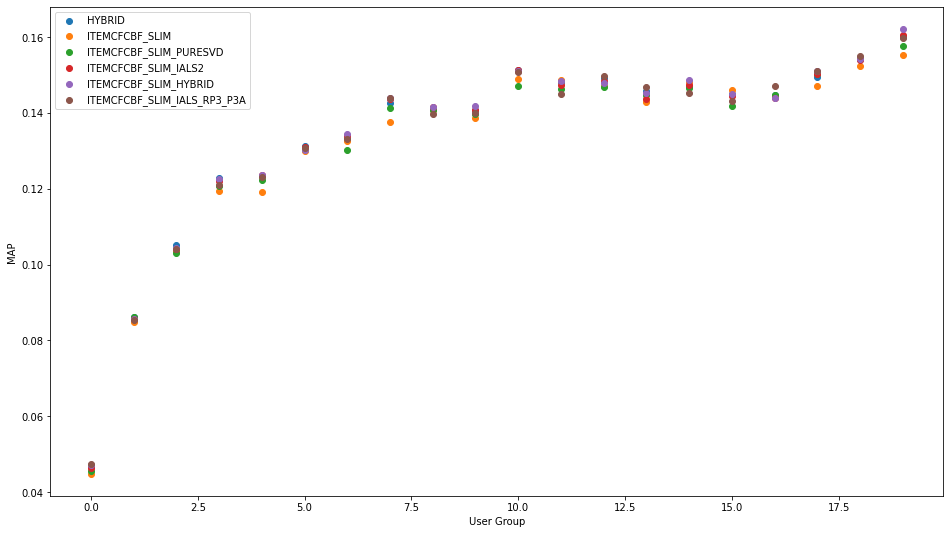

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

In [86]:
##ITEMCFCBF
ITEMCFCBF2=ItemKNN_CFCBF_Hybrid_Recommender(ICM_train=ICM,URM_train=URM_train)
ITEMCFCBF2.fit(topK=174, shrink=54.93865189896452, similarity='cosine')
ITEMCFCBF_SLIM2 = MergeTwoModelsByScores(URM_train = stacked_train, recommenders=[ITEMCFCBF2,SLIME_recommender])
ITEMCFCBF_SLIM2.fit(alpha=0.006419859589518687,beta=1.0)
ITEMCFCBF_SLIM_IALS3 = MergeTwoModelsByScores(URM_train = stacked_train, recommenders=[ITEMCFCBF_SLIM2,IALS_recommender])
ITEMCFCBF_SLIM_IALS3.fit(alpha=0.7751267998183894,beta=0.35391338107827336)

ItemKNN_CFCBF_HybridRecommender: ICM Detected 1 ( 0.0%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 141.31 column/sec. Elapsed time 2.13 min


In [88]:
##ITEMCFCBF_SLIM2
from src.HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from skopt.space import Real, Integer
from src.HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs

hyperparameters_range_dictionary = {
    "alpha": Real(0.0, 1.0),
    "beta": Real(0.0, 1.0)
}


recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[stacked_train,[ITEMCFCBF2,SLIME_recommender]],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)
recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[URM_train_validation],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)

tuning_class = SearchBayesianSkopt(recommender_class=MergeTwoModelsByScores,
                                   evaluator_validation=evaluator_validation,
                                   evaluator_test=evaluator_test)

n_cases = 50
n_random_starts = n_cases * 0.3
output_folder_path = "logs/"

tuning_class.search(recommender_input_args=recommender_input_args,
                    hyperparameter_search_space=hyperparameters_range_dictionary,
                    metric_to_optimize="MAP",
                    cutoff_to_optimize=10,
                    n_cases=n_cases,
                    n_random_starts=n_random_starts,
                    output_folder_path=output_folder_path,
                    output_file_name_root=MergeTwoModelsByScores.RECOMMENDER_NAME,
                    save_model="best"
                    )

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'alpha': 0.31781452652552605, 'beta': 0.5158940468543051}
EvaluatorHoldout: Processed 13627 (100.0%) in 1.00 min. Users per second: 227
SearchBayesianSkopt: New best config found. Config 0: {'alpha': 0.31781452652552605, 'beta': 0.5158940468543051} - results: PRECISION: 0.2001688, PRECISION_RECALL_MIN_DEN: 0.2030883, RECALL: 0.0551267, MAP: 0.0952256, MAP_MIN_DEN: 0.0965835, MRR: 0.4243114, NDCG: 0.2104536, F1: 0.0864461, HIT_RATE: 0.8641667, ARHR_ALL_HITS: 0.6338775, NOVELTY: 0.0053112, AVERAGE_POPULARITY: 0.6649500, DIVERSITY_MEAN_INTER_LIST: 0.8015924, DIVERSITY_HERFINDAHL: 0.9801534, COVERAGE_ITEM: 0.0563708, COVERAGE_ITEM_CORRECT: 0.0256936, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8627106, DIVERSITY_GINI: 0.0039714, SHANNON_ENTROPY: 6.3628467, RATIO_DIVERSITY_HERFINDAHL: 0.9805216, RATIO_DIVERSITY_GINI: 0.0153151, RATIO_SHANNON_ENTROPY: 0.5113094, RATIO_AVERAGE_POPULARITY

EvaluatorHoldout: Processed 13627 (100.0%) in 25.51 sec. Users per second: 534
SearchBayesianSkopt: Config 6 is suboptimal. Config: {'alpha': 0.20584404228581793, 'beta': 0.22167856660129343} - results: PRECISION: 0.1990827, PRECISION_RECALL_MIN_DEN: 0.2019499, RECALL: 0.0546555, MAP: 0.0944924, MAP_MIN_DEN: 0.0957878, MRR: 0.4219485, NDCG: 0.2091205, F1: 0.0857653, HIT_RATE: 0.8626991, ARHR_ALL_HITS: 0.6296533, NOVELTY: 0.0053087, AVERAGE_POPULARITY: 0.6660882, DIVERSITY_MEAN_INTER_LIST: 0.7999686, DIVERSITY_HERFINDAHL: 0.9799910, COVERAGE_ITEM: 0.0545434, COVERAGE_ITEM_CORRECT: 0.0251952, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8612454, DIVERSITY_GINI: 0.0038836, SHANNON_ENTROPY: 6.3395872, RATIO_DIVERSITY_HERFINDAHL: 0.9803592, RATIO_DIVERSITY_GINI: 0.0149767, RATIO_SHANNON_ENTROPY: 0.5094403, RATIO_AVERAGE_POPULARITY: 3.3304098, RATIO_NOVELTY: 0.0277701, 

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 25.7771
Function value obtained: -0.0945
Current

EvaluatorHoldout: Processed 13627 (100.0%) in 18.26 sec. Users per second: 746
SearchBayesianSkopt: Config 12 is suboptimal. Config: {'alpha': 0.952748985813361, 'beta': 0.29948823470617264} - results: PRECISION: 0.1970059, PRECISION_RECALL_MIN_DEN: 0.1997046, RECALL: 0.0536606, MAP: 0.0932266, MAP_MIN_DEN: 0.0944240, MRR: 0.4181524, NDCG: 0.2067346, F1: 0.0843468, HIT_RATE: 0.8580759, ARHR_ALL_HITS: 0.6224861, NOVELTY: 0.0053059, AVERAGE_POPULARITY: 0.6674573, DIVERSITY_MEAN_INTER_LIST: 0.7979162, DIVERSITY_HERFINDAHL: 0.9797858, COVERAGE_ITEM: 0.0527161, COVERAGE_ITEM_CORRECT: 0.0242538, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8566300, DIVERSITY_GINI: 0.0037821, SHANNON_ENTROPY: 6.3102642, RATIO_DIVERSITY_HERFINDAHL: 0.9801539, RATIO_DIVERSITY_GINI: 0.0145850, RATIO_SHANNON_ENTROPY: 0.5070839, RATIO_AVERAGE_POPULARITY: 3.3372550, RATIO_NOVELTY: 0.0277551, 

Iteration No: 13 ended. Evaluation done at random point.
Time taken: 18.4303
Function value obtained: -0.0932
Current

SearchBayesianSkopt: Config 18 is suboptimal. Config: {'alpha': 0.9973637148429992, 'beta': 0.6200832503052026} - results: PRECISION: 0.1978645, PRECISION_RECALL_MIN_DEN: 0.2006075, RECALL: 0.0540522, MAP: 0.0937549, MAP_MIN_DEN: 0.0949769, MRR: 0.4195905, NDCG: 0.2076956, F1: 0.0849091, HIT_RATE: 0.8596903, ARHR_ALL_HITS: 0.6253680, NOVELTY: 0.0053069, AVERAGE_POPULARITY: 0.6670123, DIVERSITY_MEAN_INTER_LIST: 0.7985880, DIVERSITY_HERFINDAHL: 0.9798529, COVERAGE_ITEM: 0.0529930, COVERAGE_ITEM_CORRECT: 0.0243646, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8582418, DIVERSITY_GINI: 0.0038129, SHANNON_ENTROPY: 6.3203415, RATIO_DIVERSITY_HERFINDAHL: 0.9802211, RATIO_DIVERSITY_GINI: 0.0147041, RATIO_SHANNON_ENTROPY: 0.5078937, RATIO_AVERAGE_POPULARITY: 3.3350304, RATIO_NOVELTY: 0.0277602, 

Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 17.9344
Function value obtained: -0.0938
Current minimum: -0.1046
Iteration No: 20 started. Searching for the next o

EvaluatorHoldout: Processed 13627 (100.0%) in 17.92 sec. Users per second: 761
SearchBayesianSkopt: Config 25 is suboptimal. Config: {'alpha': 0.8909782989552727, 'beta': 0.05797418608932638} - results: PRECISION: 0.1964556, PRECISION_RECALL_MIN_DEN: 0.1990634, RECALL: 0.0532777, MAP: 0.0929388, MAP_MIN_DEN: 0.0941010, MRR: 0.4173218, NDCG: 0.2061083, F1: 0.0838230, HIT_RATE: 0.8563881, ARHR_ALL_HITS: 0.6207666, NOVELTY: 0.0053052, AVERAGE_POPULARITY: 0.6677298, DIVERSITY_MEAN_INTER_LIST: 0.7974739, DIVERSITY_HERFINDAHL: 0.9797415, COVERAGE_ITEM: 0.0519962, COVERAGE_ITEM_CORRECT: 0.0241431, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8549451, DIVERSITY_GINI: 0.0037487, SHANNON_ENTROPY: 6.3018584, RATIO_DIVERSITY_HERFINDAHL: 0.9801096, RATIO_DIVERSITY_GINI: 0.0144564, RATIO_SHANNON_ENTROPY: 0.5064084, RATIO_AVERAGE_POPULARITY: 3.3386179, RATIO_NOVELTY: 0.0277514, 

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 18.2202
Function value obtained: -0.

EvaluatorHoldout: Processed 13627 (100.0%) in 17.52 sec. Users per second: 778
SearchBayesianSkopt: Config 32 is suboptimal. Config: {'alpha': 0.012624029400436701, 'beta': 1.0} - results: PRECISION: 0.2193880, PRECISION_RECALL_MIN_DEN: 0.2229739, RECALL: 0.0624567, MAP: 0.1042825, MAP_MIN_DEN: 0.1058459, MRR: 0.4419275, NDCG: 0.2277722, F1: 0.0972326, HIT_RATE: 0.8974829, ARHR_ALL_HITS: 0.6777436, NOVELTY: 0.0055151, AVERAGE_POPULARITY: 0.5583053, DIVERSITY_MEAN_INTER_LIST: 0.9036408, DIVERSITY_HERFINDAHL: 0.9903574, COVERAGE_ITEM: 0.1008361, COVERAGE_ITEM_CORRECT: 0.0520516, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8959707, DIVERSITY_GINI: 0.0111056, SHANNON_ENTROPY: 7.7887157, RATIO_DIVERSITY_HERFINDAHL: 0.9907295, RATIO_DIVERSITY_GINI: 0.0428272, RATIO_SHANNON_ENTROPY: 0.6258902, RATIO_AVERAGE_POPULARITY: 2.7915002, RATIO_NOVELTY: 0.0288495, 

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 17.9838
Function value obtained: -0.1043
Current m

EvaluatorHoldout: Processed 13627 (100.0%) in 17.47 sec. Users per second: 780
SearchBayesianSkopt: Config 39 is suboptimal. Config: {'alpha': 0.18761134830874765, 'beta': 0.9981891400930608} - results: PRECISION: 0.2057973, PRECISION_RECALL_MIN_DEN: 0.2091887, RECALL: 0.0578637, MAP: 0.0983389, MAP_MIN_DEN: 0.0998268, MRR: 0.4334267, NDCG: 0.2164256, F1: 0.0903296, HIT_RATE: 0.8782564, ARHR_ALL_HITS: 0.6510942, NOVELTY: 0.0053287, AVERAGE_POPULARITY: 0.6557015, DIVERSITY_MEAN_INTER_LIST: 0.8146576, DIVERSITY_HERFINDAHL: 0.9814598, COVERAGE_ITEM: 0.0647876, COVERAGE_ITEM_CORRECT: 0.0289053, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8767766, DIVERSITY_GINI: 0.0045818, SHANNON_ENTROPY: 6.5312140, RATIO_DIVERSITY_HERFINDAHL: 0.9818285, RATIO_DIVERSITY_GINI: 0.0176691, RATIO_SHANNON_ENTROPY: 0.5248391, RATIO_AVERAGE_POPULARITY: 3.2784770, RATIO_NOVELTY: 0.0278747, 

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 17.8709
Function value obtained: -0.

EvaluatorHoldout: Processed 13627 (100.0%) in 17.08 sec. Users per second: 798
SearchBayesianSkopt: Config 46 is suboptimal. Config: {'alpha': 0.006463588690469998, 'beta': 1.0} - results: PRECISION: 0.2198430, PRECISION_RECALL_MIN_DEN: 0.2233976, RECALL: 0.0626325, MAP: 0.1044478, MAP_MIN_DEN: 0.1060068, MRR: 0.4429749, NDCG: 0.2281586, F1: 0.0974903, HIT_RATE: 0.8991708, ARHR_ALL_HITS: 0.6787639, NOVELTY: 0.0055693, AVERAGE_POPULARITY: 0.5330371, DIVERSITY_MEAN_INTER_LIST: 0.9175152, DIVERSITY_HERFINDAHL: 0.9917448, COVERAGE_ITEM: 0.1069827, COVERAGE_ITEM_CORRECT: 0.0574229, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8976557, DIVERSITY_GINI: 0.0131228, SHANNON_ENTROPY: 8.0464811, RATIO_DIVERSITY_HERFINDAHL: 0.9921174, RATIO_DIVERSITY_GINI: 0.0506061, RATIO_SHANNON_ENTROPY: 0.6466039, RATIO_AVERAGE_POPULARITY: 2.6651606, RATIO_NOVELTY: 0.0291331, 

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 17.4834
Function value obtained: -0.1044
Current m

In [89]:
ITEMCFCBF_SLIM2 = MergeTwoModelsByScores(URM_train = stacked_train, recommenders=[ITEMCFCBF2,SLIME_recommender])
ITEMCFCBF_SLIM2.fit(alpha=0.003734754950301623,beta=0.9939847345087647)

In [91]:
##ITEMCFCBF_SLIM_IALS2
from src.HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from skopt.space import Real, Integer
from src.HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs

hyperparameters_range_dictionary = {
    "alpha": Real(0.0, 1.0),
    "beta": Real(0.0, 1.0)
}


recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[stacked_train,[ITEMCFCBF_SLIM2,IALS_recommender]],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)
recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[URM_train_validation],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)

tuning_class = SearchBayesianSkopt(recommender_class=MergeTwoModelsByScores,
                                   evaluator_validation=evaluator_validation,
                                   evaluator_test=evaluator_test)

n_cases = 50
n_random_starts = n_cases * 0.3
output_folder_path = "logs/"

tuning_class.search(recommender_input_args=recommender_input_args,
                    hyperparameter_search_space=hyperparameters_range_dictionary,
                    metric_to_optimize="MAP",
                    cutoff_to_optimize=10,
                    n_cases=n_cases,
                    n_random_starts=n_random_starts,
                    output_folder_path=output_folder_path,
                    output_file_name_root=MergeTwoModelsByScores.RECOMMENDER_NAME,
                    save_model="best"
                    )

Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'alpha': 0.6358204969375563, 'beta': 0.9206291572589242}
EvaluatorHoldout: Processed 13627 (100.0%) in 20.32 sec. Users per second: 670
SearchBayesianSkopt: New best config found. Config 0: {'alpha': 0.6358204969375563, 'beta': 0.9206291572589242} - results: PRECISION: 0.2191898, PRECISION_RECALL_MIN_DEN: 0.2226651, RECALL: 0.0619441, MAP: 0.1042917, MAP_MIN_DEN: 0.1058286, MRR: 0.4415520, NDCG: 0.2274958, F1: 0.0965911, HIT_RATE: 0.8940339, ARHR_ALL_HITS: 0.6768643, NOVELTY: 0.0055462, AVERAGE_POPULARITY: 0.5279531, DIVERSITY_MEAN_INTER_LIST: 0.9274011, DIVERSITY_HERFINDAHL: 0.9927333, COVERAGE_ITEM: 0.0668919, COVERAGE_ITEM_CORRECT: 0.0438562, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8925275, DIVERSITY_GINI: 0.0114469, SHANNON_ENTROPY: 8.0077866, RATIO_DIVERSITY_HERFINDAHL: 0.9931063, RATIO_DIVERSITY_GINI: 0.0441434, RATIO_SHANNON_ENTROPY: 0.6434944, RATIO_AVERAGE_POPULARITY:

EvaluatorHoldout: Processed 13627 (100.0%) in 20.14 sec. Users per second: 677
SearchBayesianSkopt: Config 5 is suboptimal. Config: {'alpha': 0.11393407469219466, 'beta': 0.9126136368252624} - results: PRECISION: 0.2146988, PRECISION_RECALL_MIN_DEN: 0.2180571, RECALL: 0.0605440, MAP: 0.1018154, MAP_MIN_DEN: 0.1033026, MRR: 0.4369841, NDCG: 0.2232126, F1: 0.0944527, HIT_RATE: 0.8907316, ARHR_ALL_HITS: 0.6653336, NOVELTY: 0.0055536, AVERAGE_POPULARITY: 0.5187287, DIVERSITY_MEAN_INTER_LIST: 0.9346925, DIVERSITY_HERFINDAHL: 0.9934624, COVERAGE_ITEM: 0.0561493, COVERAGE_ITEM_CORRECT: 0.0415305, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8892308, DIVERSITY_GINI: 0.0117310, SHANNON_ENTROPY: 8.0782120, RATIO_DIVERSITY_HERFINDAHL: 0.9938357, RATIO_DIVERSITY_GINI: 0.0452389, RATIO_SHANNON_ENTROPY: 0.6491537, RATIO_AVERAGE_POPULARITY: 2.5936194, RATIO_NOVELTY: 0.0290507, 

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 20.2881
Function value obtained: -0.1018
Current 

EvaluatorHoldout: Processed 13627 (100.0%) in 20.05 sec. Users per second: 680
SearchBayesianSkopt: Config 12 is suboptimal. Config: {'alpha': 0.4128110742250324, 'beta': 0.46697671520271833} - results: PRECISION: 0.2201732, PRECISION_RECALL_MIN_DEN: 0.2236011, RECALL: 0.0621829, MAP: 0.1047769, MAP_MIN_DEN: 0.1063352, MRR: 0.4425361, NDCG: 0.2284176, F1: 0.0969769, HIT_RATE: 0.8962354, ARHR_ALL_HITS: 0.6793455, NOVELTY: 0.0055467, AVERAGE_POPULARITY: 0.5291170, DIVERSITY_MEAN_INTER_LIST: 0.9260603, DIVERSITY_HERFINDAHL: 0.9925992, COVERAGE_ITEM: 0.0707680, COVERAGE_ITEM_CORRECT: 0.0447422, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8947253, DIVERSITY_GINI: 0.0114914, SHANNON_ENTROPY: 8.0024747, RATIO_DIVERSITY_HERFINDAHL: 0.9929722, RATIO_DIVERSITY_GINI: 0.0443149, RATIO_SHANNON_ENTROPY: 0.6430676, RATIO_AVERAGE_POPULARITY: 2.6455604, RATIO_NOVELTY: 0.0290149, 

Iteration No: 13 ended. Evaluation done at random point.
Time taken: 20.2033
Function value obtained: -0.1048
Curren

Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 22.8885
Function value obtained: -0.1054
Current minimum: -0.1054
Iteration No: 20 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 1.0, 'beta': 0.747499225277656}
EvaluatorHoldout: Processed 13627 (100.0%) in 19.72 sec. Users per second: 691
SearchBayesianSkopt: Config 19 is suboptimal. Config: {'alpha': 1.0, 'beta': 0.747499225277656} - results: PRECISION: 0.2212152, PRECISION_RECALL_MIN_DEN: 0.2248223, RECALL: 0.0629459, MAP: 0.1051319, MAP_MIN_DEN: 0.1067536, MRR: 0.4424530, NDCG: 0.2292344, F1: 0.0980049, HIT_RATE: 0.8988038, ARHR_ALL_HITS: 0.6805367, NOVELTY: 0.0055508, AVERAGE_POPULARITY: 0.5298394, DIVERSITY_MEAN_INTER_LIST: 0.9243659, DIVERSITY_HERFINDAHL: 0.9924298, COVERAGE_ITEM: 0.0771914, COVERAGE_ITEM_CORRECT: 0.0470126, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8972894, DIVERSITY_GINI: 0.0116892, SHANNON_ENTROPY: 8.0066109, RATIO_DIVERSITY

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 20.5148
Function value obtained: -0.1051
Current minimum: -0.1054
Iteration No: 27 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.7391580298874307, 'beta': 0.5408873624618711}
EvaluatorHoldout: Processed 13627 (100.0%) in 20.51 sec. Users per second: 664
SearchBayesianSkopt: Config 26 is suboptimal. Config: {'alpha': 0.7391580298874307, 'beta': 0.5408873624618711} - results: PRECISION: 0.2212519, PRECISION_RECALL_MIN_DEN: 0.2248679, RECALL: 0.0629575, MAP: 0.1051240, MAP_MIN_DEN: 0.1067518, MRR: 0.4424038, NDCG: 0.2292559, F1: 0.0980226, HIT_RATE: 0.8990974, ARHR_ALL_HITS: 0.6805060, NOVELTY: 0.0055510, AVERAGE_POPULARITY: 0.5298649, DIVERSITY_MEAN_INTER_LIST: 0.9242535, DIVERSITY_HERFINDAHL: 0.9924186, COVERAGE_ITEM: 0.0774683, COVERAGE_ITEM_CORRECT: 0.0470126, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8975824, DIVERSITY_GINI: 0.0116999, SHANNON_ENT

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 20.5640
Function value obtained: -0.1038
Current minimum: -0.1055
Iteration No: 33 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.9991263536280637, 'beta': 0.33614024531785874}
EvaluatorHoldout: Processed 13627 (100.0%) in 20.47 sec. Users per second: 666
SearchBayesianSkopt: Config 32 is suboptimal. Config: {'alpha': 0.9991263536280637, 'beta': 0.33614024531785874} - results: PRECISION: 0.2217730, PRECISION_RECALL_MIN_DEN: 0.2253603, RECALL: 0.0630940, MAP: 0.1054496, MAP_MIN_DEN: 0.1070305, MRR: 0.4441100, NDCG: 0.2298249, F1: 0.0982392, HIT_RATE: 0.9004917, ARHR_ALL_HITS: 0.6827352, NOVELTY: 0.0055634, AVERAGE_POPULARITY: 0.5287417, DIVERSITY_MEAN_INTER_LIST: 0.9224834, DIVERSITY_HERFINDAHL: 0.9922416, COVERAGE_ITEM: 0.0905366, COVERAGE_ITEM_CORRECT: 0.0512764, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8989744, DIVERSITY_GINI: 0.0123920, SHANNON_E

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 20.3136
Function value obtained: -0.1046
Current minimum: -0.1055
Iteration No: 40 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.9258757687727466, 'beta': 0.2702135155238265}
EvaluatorHoldout: Processed 13627 (100.0%) in 20.07 sec. Users per second: 679
SearchBayesianSkopt: Config 39 is suboptimal. Config: {'alpha': 0.9258757687727466, 'beta': 0.2702135155238265} - results: PRECISION: 0.2214647, PRECISION_RECALL_MIN_DEN: 0.2250260, RECALL: 0.0630174, MAP: 0.1053519, MAP_MIN_DEN: 0.1069368, MRR: 0.4440487, NDCG: 0.2296110, F1: 0.0981161, HIT_RATE: 0.9010787, ARHR_ALL_HITS: 0.6823256, NOVELTY: 0.0055663, AVERAGE_POPULARITY: 0.5281545, DIVERSITY_MEAN_INTER_LIST: 0.9224287, DIVERSITY_HERFINDAHL: 0.9922361, COVERAGE_ITEM: 0.0929177, COVERAGE_ITEM_CORRECT: 0.0519409, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8995604, DIVERSITY_GINI: 0.0125450, SHANNON_ENT

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 20.5814
Function value obtained: -0.1026
Current minimum: -0.1055
Iteration No: 47 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.005288454606051097, 'beta': 0.35362617406799607}
EvaluatorHoldout: Processed 13627 (100.0%) in 20.37 sec. Users per second: 669
SearchBayesianSkopt: Config 46 is suboptimal. Config: {'alpha': 0.005288454606051097, 'beta': 0.35362617406799607} - results: PRECISION: 0.2128422, PRECISION_RECALL_MIN_DEN: 0.2160551, RECALL: 0.0597883, MAP: 0.1007737, MAP_MIN_DEN: 0.1022612, MRR: 0.4359180, NDCG: 0.2215176, F1: 0.0933532, HIT_RATE: 0.8880164, ARHR_ALL_HITS: 0.6611682, NOVELTY: 0.0055594, AVERAGE_POPULARITY: 0.5145186, DIVERSITY_MEAN_INTER_LIST: 0.9372531, DIVERSITY_HERFINDAHL: 0.9937184, COVERAGE_ITEM: 0.0536021, COVERAGE_ITEM_CORRECT: 0.0414198, COVERAGE_USER: 0.9983150, COVERAGE_USER_CORRECT: 0.8865201, DIVERSITY_GINI: 0.0119856, SHANN

In [92]:
ITEMCFCBF_SLIM_IALS4 = MergeTwoModelsByScores(URM_train = stacked_train, recommenders=[ITEMCFCBF_SLIM2,IALS_recommender])
ITEMCFCBF_SLIM_IALS4.fit(alpha=0.41836583477030864,beta=0.14407384453859143)

In [95]:
result_df, _ = evaluator_test.evaluateRecommender(ITEMCFCBF_SLIM_IALS_HYBRID)
print(result_df.loc[10])

NameError: name 'ITEMCFCBF_SLIM_IALS_HYBRID' is not defined

In [93]:
result_df, _ = evaluator_test.evaluateRecommender(ITEMCFCBF_SLIM_IALS4)
print(result_df.loc[10])

EvaluatorHoldout: Processed 682 (100.0%) in 2.06 sec. Users per second: 331
PRECISION                     0.302053
PRECISION_RECALL_MIN_DEN      0.302053
RECALL                        0.019427
MAP                           0.159863
MAP_MIN_DEN                   0.159863
MRR                           0.540094
NDCG                          0.308885
F1                            0.036506
HIT_RATE                      0.969208
ARHR_ALL_HITS                 0.922893
NOVELTY                       0.005633
AVERAGE_POPULARITY            0.478156
DIVERSITY_MEAN_INTER_LIST     0.949486
DIVERSITY_HERFINDAHL          0.994809
COVERAGE_ITEM                 0.030677
COVERAGE_ITEM_CORRECT          0.02143
COVERAGE_USER                      1.0
COVERAGE_USER_CORRECT         0.969208
DIVERSITY_GINI                0.011645
SHANNON_ENTROPY               8.124713
RATIO_DIVERSITY_HERFINDAHL    0.995183
RATIO_DIVERSITY_GINI          0.044909
RATIO_SHANNON_ENTROPY          0.65289
RATIO_AVERAGE_POPULARITY   